## Vizualize data

In [ ]:
!pip install open3d

### Full fidelity sample

DatasetDict({
    train: Dataset({
        features: ['inputs', 'label'],
        num_rows: 9843
    })
    test: Dataset({
        features: ['inputs', 'label'],
        num_rows: 2468
    })
})
Before: (8192, 3)
After: (5819, 3)


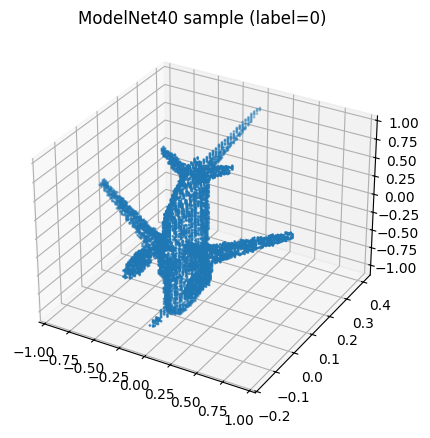

In [32]:
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt

# 1) Load
ds = load_dataset("jxie/modelnet40")  # has train/test splits in parquet
print(ds)

# 2) Grab a point cloud and label
ex = ds["train"][200]
pts = np.array(ex["inputs"], dtype=np.float32)   # shape ~ (2048, 3)
label = ex["label"]

pts = invdisc(disc(torch.from_numpy(pts))).numpy()
# remove duplicates
print(f"Before: {pts.shape}")
pts = np.unique(pts, axis=0)
print(f"After: {pts.shape}")

# 3) Quick scatter viz
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(pts[:,0], pts[:,1], pts[:,2], s=1)
ax.set_title(f"ModelNet40 sample (label={label})")
plt.show()


Ranges:
x: [-0.962, 0.976]
y: [-0.332, 0.297]
z: [-0.974, 0.600]


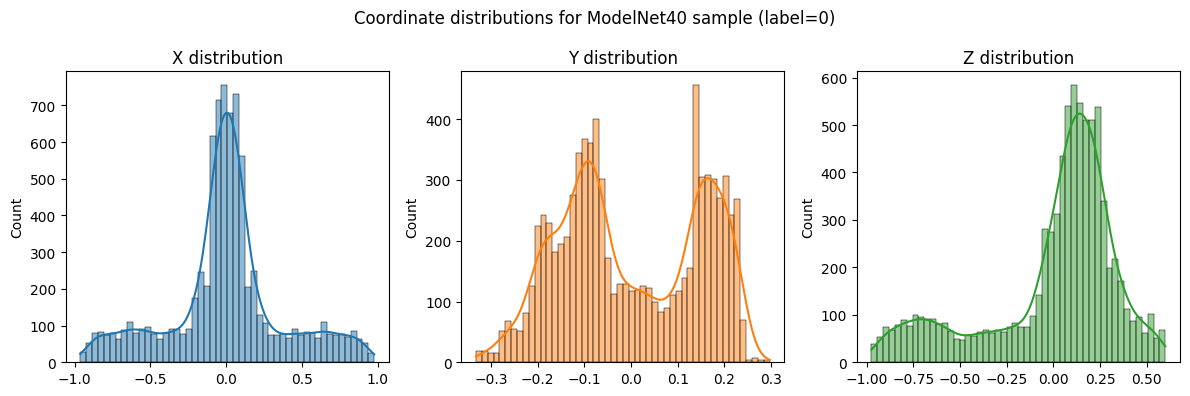

In [5]:
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Load
ds = load_dataset("jxie/modelnet40")
ex = ds["train"][0]
pts = np.array(ex["inputs"], dtype=np.float32)   # (2048, 3)
label = ex["label"]

# 2) Compute ranges
x, y, z = pts[:, 0], pts[:, 1], pts[:, 2]
print("Ranges:")
print(f"x: [{x.min():.3f}, {x.max():.3f}]")
print(f"y: [{y.min():.3f}, {y.max():.3f}]")
print(f"z: [{z.min():.3f}, {z.max():.3f}]")

# 3) Histograms with seaborn
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
sns.histplot(x, bins=50, ax=axes[0], kde=True, color="tab:blue")
axes[0].set_title("X distribution")

sns.histplot(y, bins=50, ax=axes[1], kde=True, color="tab:orange")
axes[1].set_title("Y distribution")

sns.histplot(z, bins=50, ax=axes[2], kde=True, color="tab:green")
axes[2].set_title("Z distribution")

plt.suptitle(f"Coordinate distributions for ModelNet40 sample (label={label})")
plt.tight_layout()
plt.show()


### Data processing

In [12]:
import torch
from sklearn.cluster import KMeans


def disc(
    points: torch.Tensor, n_bins: int = 128, min_val: float = -1.0, max_val: float = 1.0
) -> torch.Tensor:
    """
    Discretize 3D point cloud into integer bins [0, n_bins-1] along each axis.

    Args:
        points (torch.Tensor): (N, 3) float tensor of coordinates.
        n_bins (int): Number of bins per axis.
        min_val (float): Minimum value of the range.
        max_val (float): Maximum value of the range.

    Returns:
        torch.Tensor: (N, 3) integer tensor of bin indices in [0, n_bins-1].
    """
    scale = (n_bins - 1) / (max_val - min_val)
    out = torch.round((points - min_val) * scale).to(torch.int32)
    return torch.clamp(out, 0, n_bins - 1)


def invdisc(
    indices: torch.Tensor, n_bins: int = 128, min_val: float = -1.0, max_val: float = 1.0
) -> torch.Tensor:
    """
    Map discretized integer bins back to continuous coordinates (bin centers).

    Args:
        indices (torch.Tensor): (N, 3) integer tensor of bin indices.
        n_bins (int): Number of bins per axis.
        min_val (float): Minimum value of the range.
        max_val (float): Maximum value of the range.

    Returns:
        torch.Tensor: (N, 3) float tensor of bin center coordinates.
    """
    step = (max_val - min_val) / (n_bins - 1)
    return min_val + indices.to(torch.float32) * step




def cluster(x: torch.Tensor, K: int, seed: int = 0) -> torch.Tensor:
    """
    Run KMeans on x and return cluster centers.

    Args:
        x (torch.Tensor): (N, D) float tensor on CPU or GPU.
        K (int): number of clusters.
        seed (int): random seed for reproducibility.

    Returns:
        torch.Tensor: (K, D) float tensor of cluster centers (on same device as x).
    """
    device = x.device
    x_np = x.detach().cpu().numpy()

    km = KMeans(n_clusters=K, n_init="auto", random_state=seed)
    km.fit(x_np)

    centers = torch.from_numpy(km.cluster_centers_).to(device=device, dtype=x.dtype)
    return centers




DatasetDict({
    train: Dataset({
        features: ['inputs', 'label'],
        num_rows: 9843
    })
    test: Dataset({
        features: ['inputs', 'label'],
        num_rows: 2468
    })
})
Points: (2048, 3)


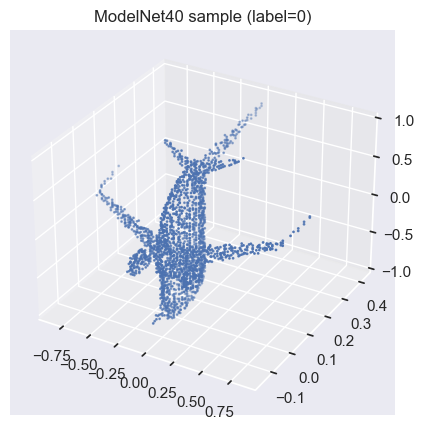

In [36]:
# Data processing

from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np

# 1) Load
ds = load_dataset("jxie/modelnet40")  # has train/test splits in parquet
print(ds)

# 2) Grab a point cloud and label
ex = ds["train"][80]
pts = np.array(ex["inputs"], dtype=np.float32)   # shape ~ (2048, 3)
label = ex["label"]

pts = invdisc(disc(cluster(torch.from_numpy(pts), K=2048))).numpy()  # (1024, 3)
print(f"Points: {pts.shape}")


# 3) Quick scatter viz
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(pts[:,0], pts[:,1], pts[:,2], s=1)
ax.set_title(f"ModelNet40 sample (label={label})")
plt.show()


## Test

moe | Dm: 10 | Do: 2 | R: 2 | H: 16: 100%|██████████| 12/12 [00:35<00:00,  2.94s/it]


Using device: cpu


Saved plot to results/plots/train_mhead_lr_0.01/loss.png
Saved plot to results/plots/train_mhead_lr_0.01/grad_norm.png
Saved plot to results/plots/train_mhead_lr_0.01/param_norm.png
Saved plot to results/plots/train_mhead_lr_0.01/logits_norm.png
Saved plot to results/plots/train_mhead_lr_0.01/epoch_time.png


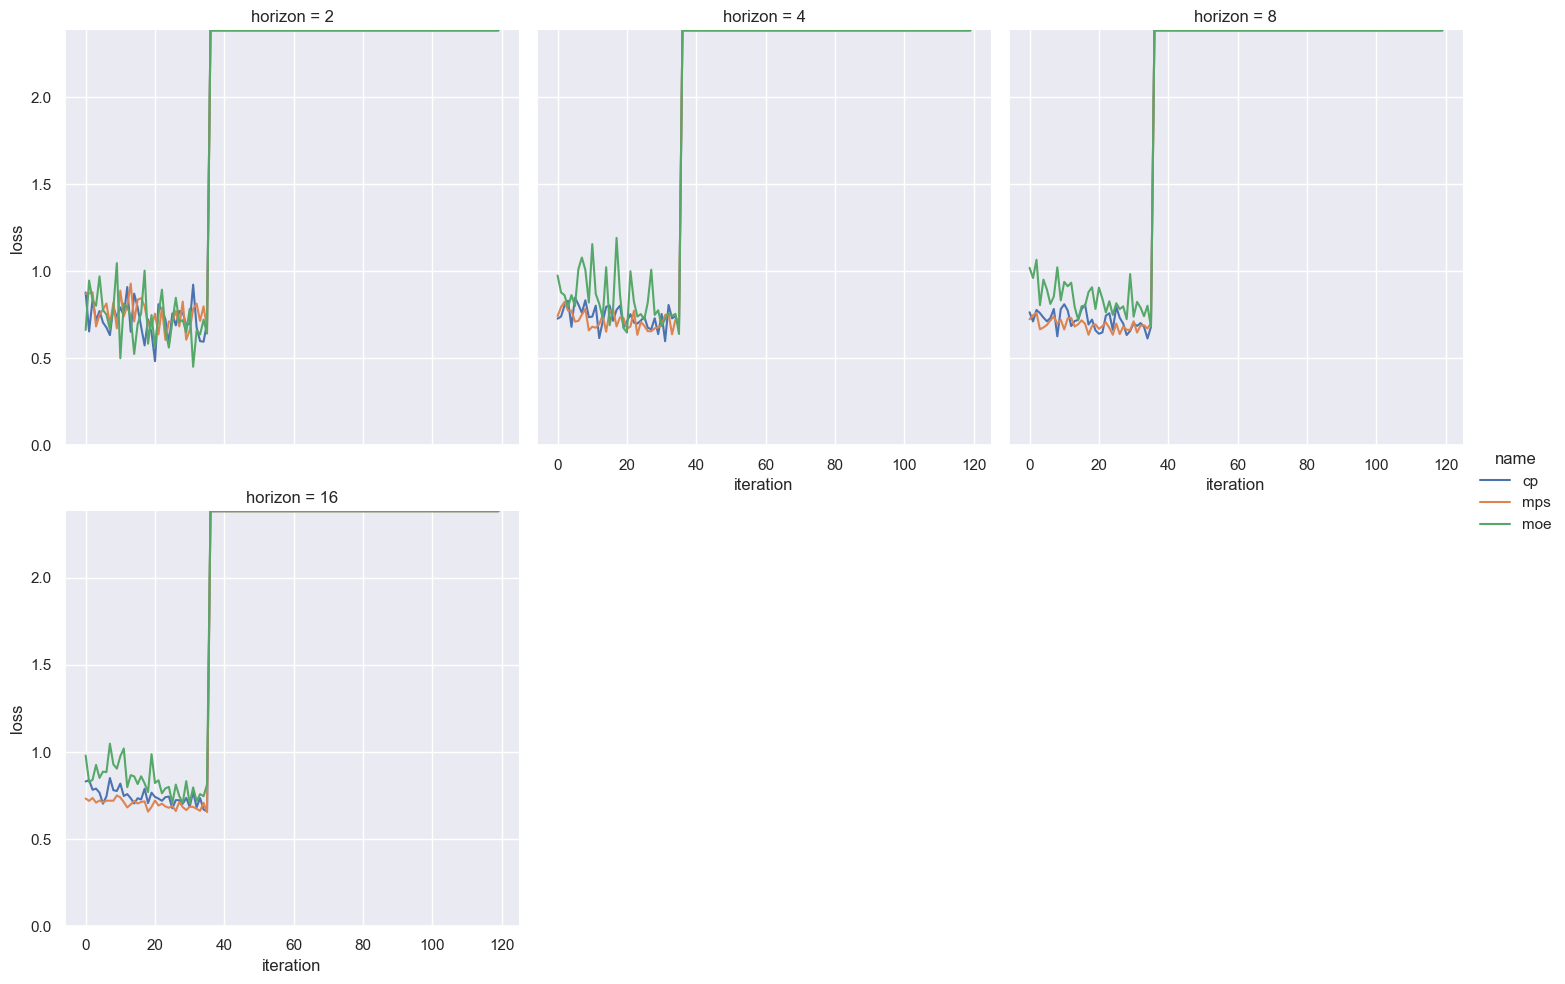

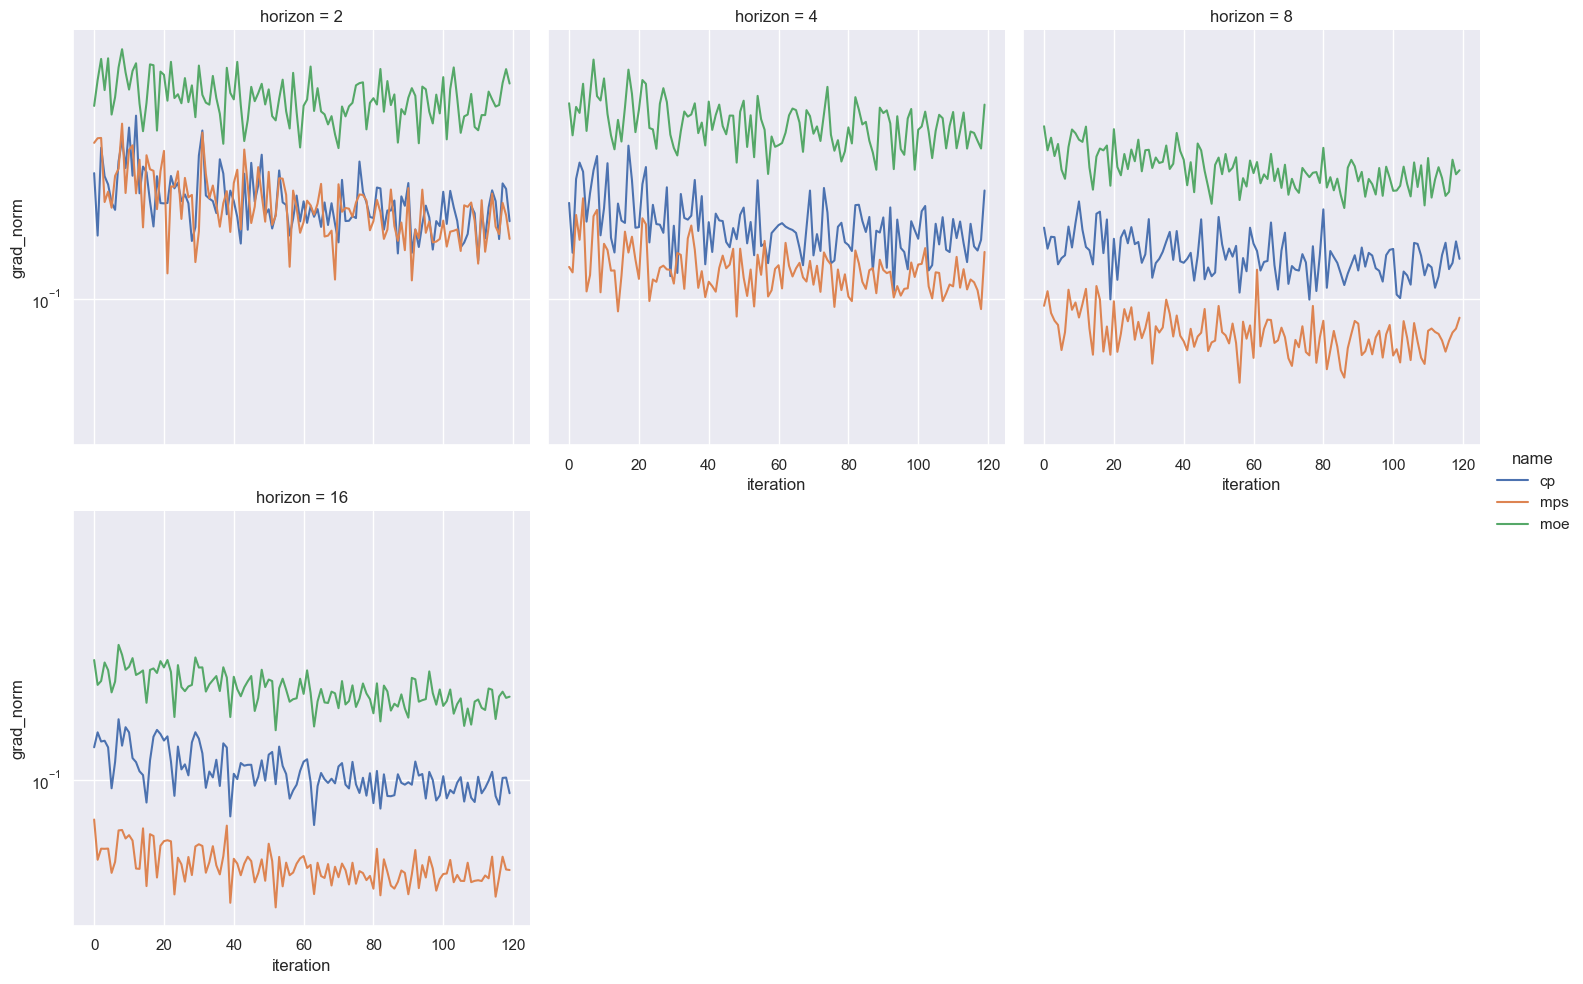

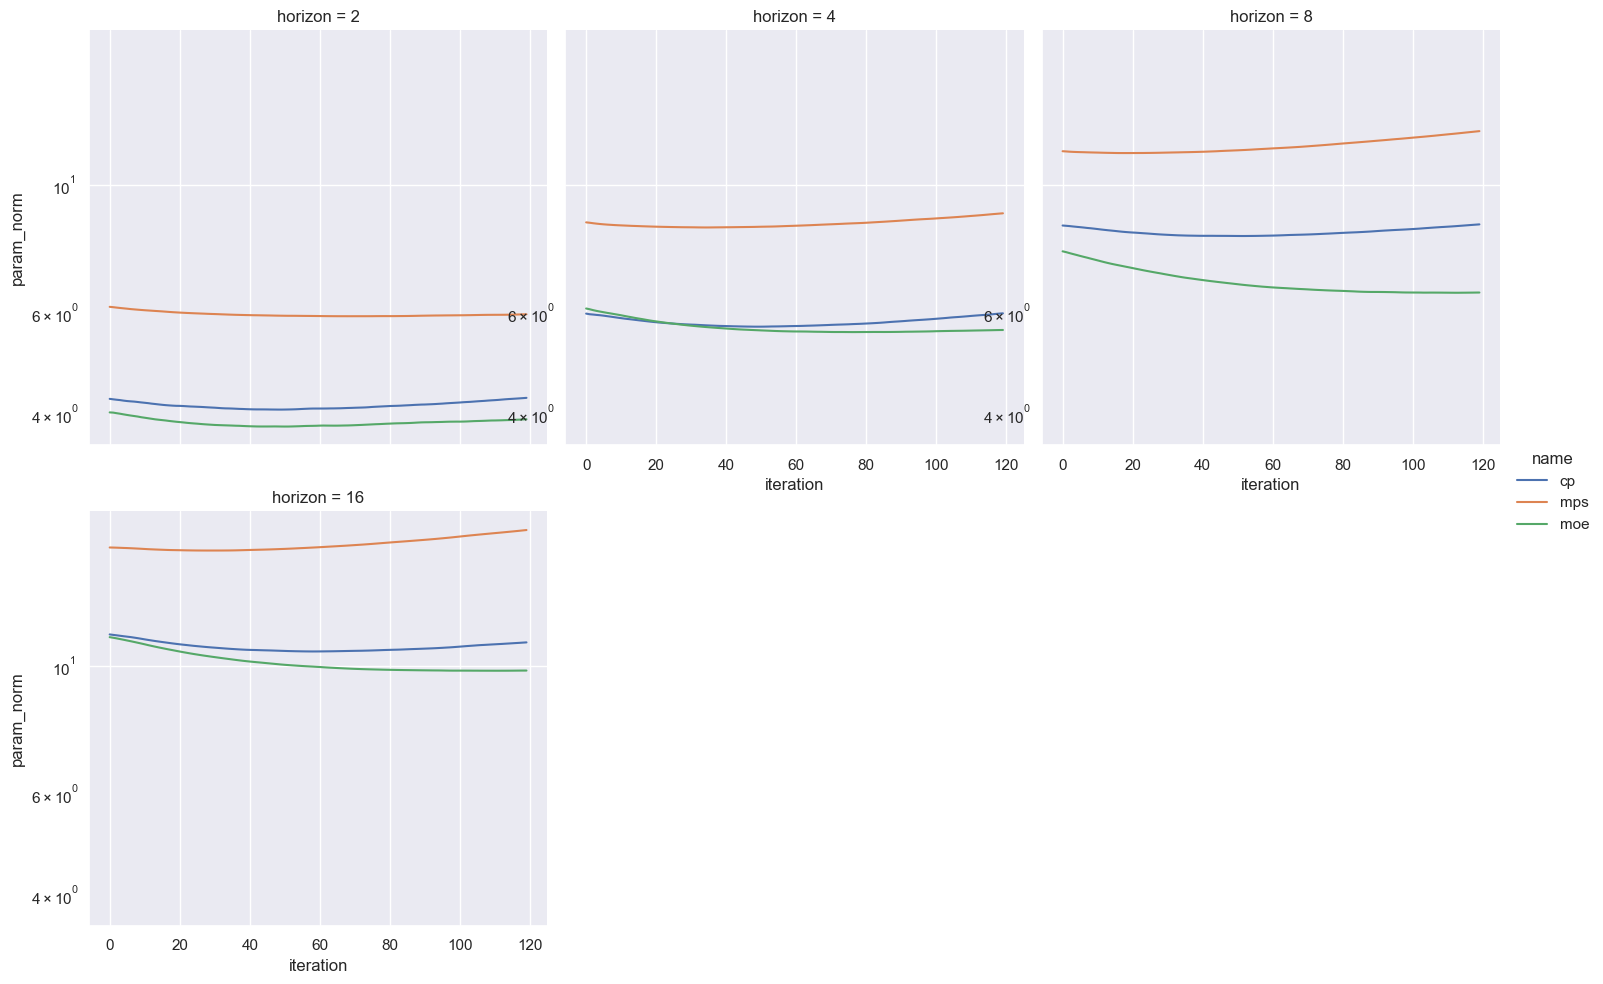

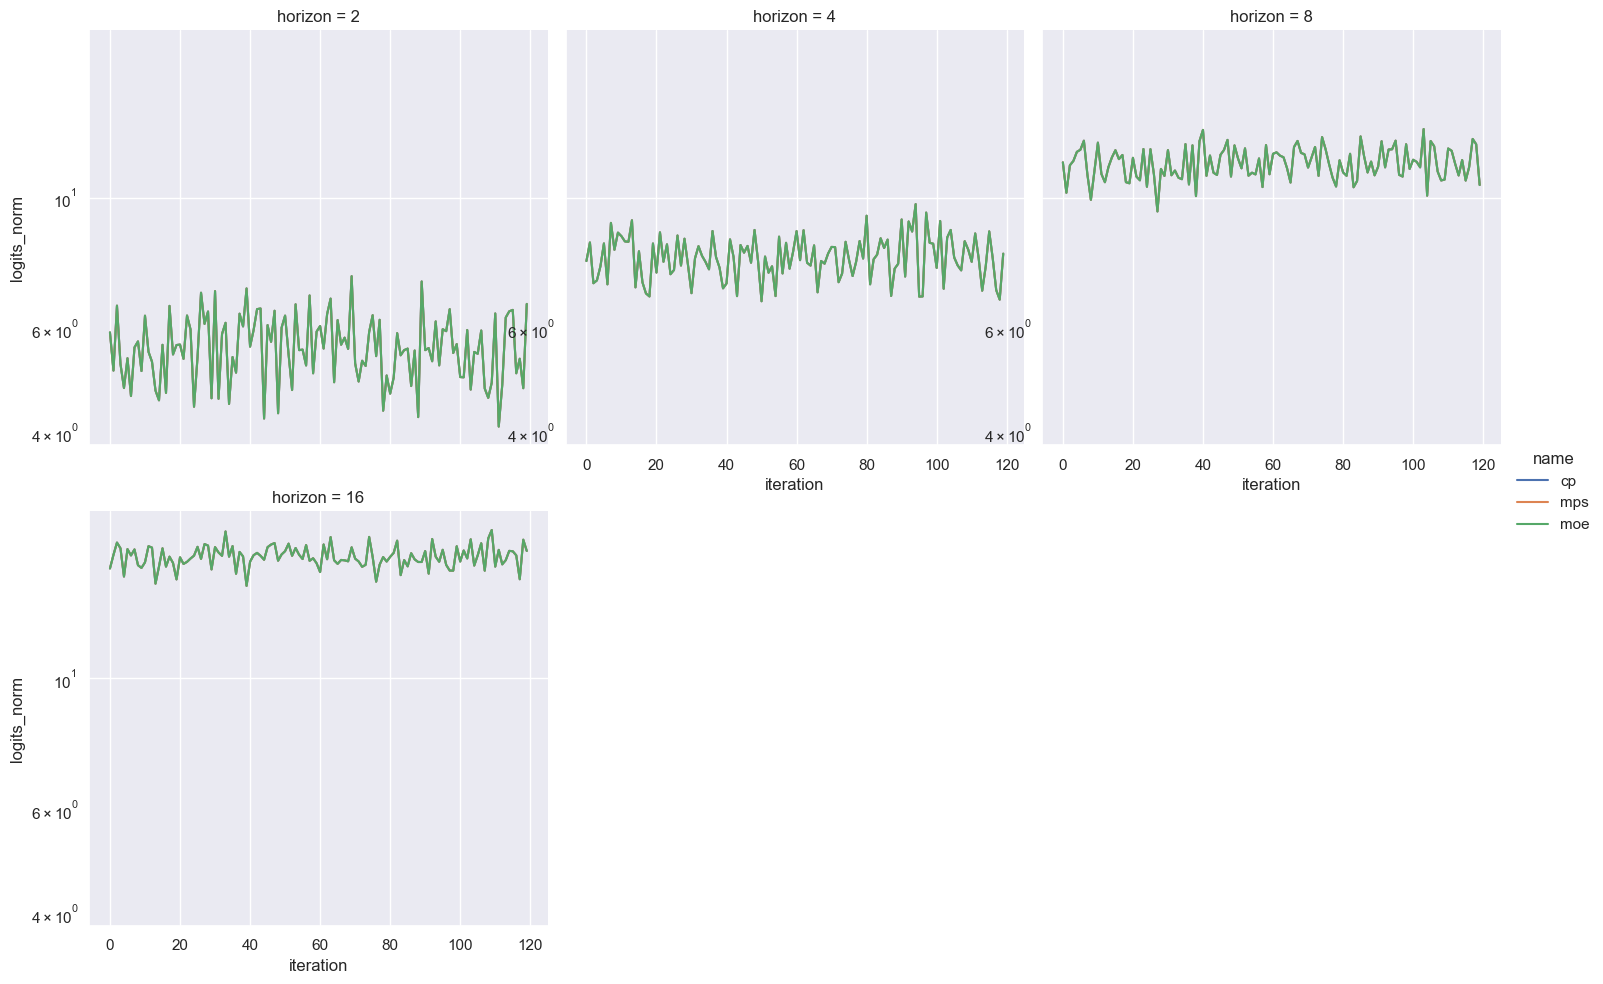

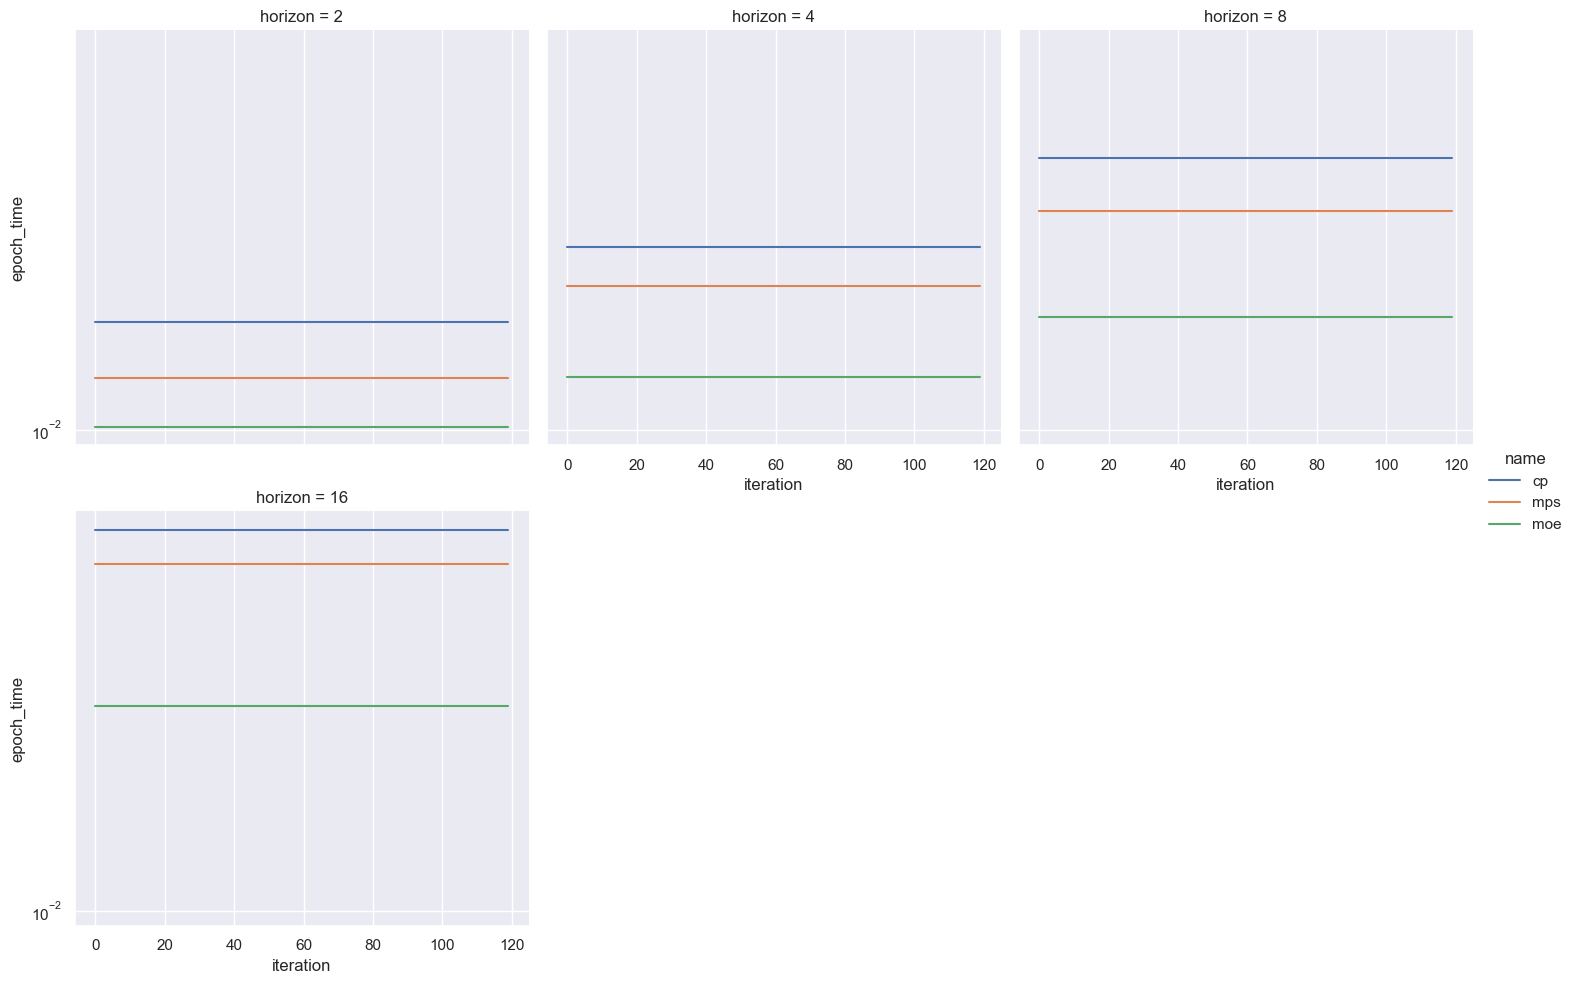

In [10]:
from ast import Str
from collections import defaultdict
import itertools
import os
import random
import time
from typing import Callable, Optional
import torch
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from mtp.mheads._abc import AbstractDisributionHeadConfig
from mtp.mheads import MHEADS
from tqdm import tqdm

# set theme
sns.set_theme()


class SyntheticDataset(data.Dataset):
    """Synthetic dataset for multi-head training."""

    def __init__(self, num_samples, d_model, horizon, d_output, seed=42):
        """
        Args:
            num_samples: Number of samples in the dataset
            d_model: Input dimension
            horizon: Output sequence length
            d_output: Output vocabulary size
            seed: Random seed for reproducibility
        """
        self.num_samples = num_samples
        self.d_model = d_model
        self.horizon = horizon
        self.d_output = d_output

        # Set seed for reproducibility
        torch.manual_seed(seed)

        # Generate all data upfront
        self.x = torch.randn(num_samples, d_model)
        self.y = torch.randint(0, 2, (num_samples, horizon)) * (d_output - 1)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


def get_grad_norm(params):
    return torch.norm(
        torch.cat([p.grad.view(-1) for p in params if p.grad is not None]), p=2
    ).item()


def get_param_norm(params):
    return torch.norm(
        torch.cat([p.view(-1) for p in params if p is not None]), p=2
    ).item()


def evaluate(model, val_dataloader):
    pass


def run_train(
    model,
    train_dataloader,
    val_dataloader,
    add_loss_dict=False,
    lr=1e-3,
    seed=42,
    device="cuda" if torch.cuda.is_available() else "cpu",
    epochs=10,
    **kwargs,
):
    """Test if CP distribution can recover a target distribution on small scale."""

    # setup
    log_dict = defaultdict(list)
    torch.manual_seed(seed)
    random.seed(seed)

    # Train
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    model.to(device)
    start_time = time.time()
    iteration = 0
    for epoch in range(epochs):
        model.train()

        for batch_idx, (x, y) in enumerate(train_dataloader):
            optimizer.zero_grad()

            x = x.to(device)
            y = y[:, : model.config.horizon].to(device)

            out = model(x, y)
            out.loss.backward()
            optimizer.step()

            if out.loss_dict is not None and add_loss_dict:
                for k, v in out.loss_dict.items():
                    # Add or create new key if not exists
                    if k not in log_dict:
                        log_dict[k] = []
                    log_dict[k].append(v)

            # also add grad_norm and loss to log_dict
            l = out.loss.item() if not torch.isnan(out.loss) else float("inf")
            if epoch > 2:
                l = float("inf")
            log_dict["loss"].append(l)
            log_dict["grad_norm"].append(get_grad_norm(model.parameters()))
            log_dict["param_norm"].append(get_param_norm(model.parameters()))
            log_dict["logits_norm"].append(out.logits.norm().item())
            log_dict["epoch"].append(epoch)
            log_dict["batch"].append(batch_idx)

            iteration += 1

            if out.loss.isnan():
                print(f"Loss is NaN at epoch {epoch}, batch {batch_idx}!")
                break

        # Print epoch summary
        if epoch % 1 == 0:
            evaluate(model, val_dataloader)

    # Add mt_name to log_dict for tracking
    log_dict["iteration"] = list(range(iteration))

    # Plot training metrics using seaborn
    return log_dict



def plot_training_metrics(
    log_dicts: list[dict],
    save_path: str = "results/plots/train_mhead_moe.png",
    is_log_metric_fn: Callable[[str], bool] = lambda x: False,
    reduce_fn: Optional[Callable[[str], str]] = None,  # e.g. "min", "max", "mean"
    **kwargs,
):
    """Plot training metrics using seaborn."""
    
    df = pd.concat(
        [pd.DataFrame(log_dict) for log_dict in log_dicts], ignore_index=True
    )

    # --- compute dynamic cutoff ---
    ycol = kwargs["y"]
    if np.isinf(df[ycol]).any():
        finite_vals = df.loc[np.isfinite(df[ycol]), ycol]
        if len(finite_vals) > 0:
            replace_inf_val = 2 * finite_vals.max()
        else:
            replace_inf_val = 1.0  # fallback if everything is inf
        df[ycol] = df[ycol].replace([np.inf, -np.inf], replace_inf_val)
    else:
        replace_inf_val = None

    if replace_inf_val is not None:
        df = df.replace([np.inf], replace_inf_val)

    g = sns.relplot(
        data=df,
        # set y limit to the same as replace_inf_val
        **kwargs,
    )

    if replace_inf_val is not None:
        # remove auto-scaling margins
        for ax in g.axes.flat:
            ax.margins(y=0)  # turn off extra padding
            ax.set_ylim(0, replace_inf_val)

    if reduce_fn is not None and reduce_fn(kwargs["y"]) is not None:
        x, y = kwargs["x"], kwargs["y"]
        gp = [c for c in df.columns if c != x]
        df = df.groupby(gp, as_index=False)[y].agg(reduce_fn(kwargs["y"]))

    if is_log_metric_fn(kwargs["y"]):
        g.set(yscale="log")

    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight")
        print(f"Saved plot to {save_path}")


def get_dataloaders(d_model, horizon, d_output, n_train, n_val, batch_size, seed=0):
    train_ds = SyntheticDataset(
        num_samples=n_train,
        d_model=d_model,
        horizon=horizon,
        d_output=d_output,
        seed=seed,
    )
    test_ds = SyntheticDataset(
        num_samples=n_val,
        d_model=d_model,
        horizon=horizon,
        d_output=d_output,
        seed=seed,
    )
    train_dl = data.DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        drop_last=True,
    )
    test_dl = data.DataLoader(
        test_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        drop_last=True,
    )
    return train_dl, test_dl


if __name__ == "__main__":

    # Common HPs
    BATCH_SIZE = 8
    LR = 1e-2
    EPOCHS = 10
    N_TRAIN = 100
    N_VAL = 10

    # Plot
    ranks = [2]
    horizons = [2,4,8,16]
    seeds = [0]
    d_models = [10]
    d_outputs = [2]
    plot_kwargs = {
        "col": "horizon",
        "col_wrap": 3,
        "hue": "name",
        "x": "iteration",
        "kind": "line",
        "is_log_metric_fn": lambda x: x != "loss",
        "reduce_fn": lambda x: "mean" if x == "epoch_time" else None,
    }

    configs = [
        {
            "name": n,
            "mt_name": n,
            "mt_kwargs": {
                "horizon": h,
                "rank": r,
                "d_model": dm,
                "d_output": do,
            },
            "seed": s,
        }
        for r, h, s, dm, do, n in itertools.product(
            ranks,
            horizons,
            seeds,
            d_models,
            d_outputs,
            [
                "cp",
                "mps",
                "moe",
            ],
        )
    ]

    log_dicts = []
    pbar = tqdm(configs)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")
    for config in configs:
        dstring = f"Dm: {config['mt_kwargs']['d_model']} | Do: {config['mt_kwargs']['d_output']} | R: {config['mt_kwargs']['rank']} | H: {config['mt_kwargs']['horizon']}"
        pbar.set_description(f"{config['mt_name']} | {dstring}")

        try:

            model = MHEADS[config["mt_name"]](
                AbstractDisributionHeadConfig(**config["mt_kwargs"])
            )

            train_dl, val_dl = get_dataloaders(
                d_model=config["mt_kwargs"]["d_model"],
                horizon=config["mt_kwargs"]["horizon"],
                d_output=config["mt_kwargs"]["d_output"],
                n_train=N_TRAIN,
                n_val=N_VAL,
                batch_size=BATCH_SIZE,
                seed=config["seed"],
            )

            start_time = time.time()

            log_dict = run_train(
                model=model,
                train_dataloader=train_dl,
                val_dataloader=val_dl,
                lr=LR,
                epochs=EPOCHS,
                device=device,
                **config,
            )

            log_dict["name"] = config["name"]
            log_dict["horizon"] = config["mt_kwargs"]["horizon"]
            log_dict["rank"] = config["mt_kwargs"]["rank"]
            log_dict["d_model"] = config["mt_kwargs"]["d_model"]
            log_dict["d_output"] = config["mt_kwargs"]["d_output"]
            log_dict["epoch_time"] = (time.time() - start_time) / EPOCHS
            log_dicts.append(log_dict)
        except Exception as e:
            print(f"Error training {config['mt_name']} | {dstring}: {e}")
            continue

        pbar.update()

    # Make plots
    save_path = f"results/plots/train_mhead_lr_{LR}"
    os.makedirs(save_path, exist_ok=True)
    for metric_key in ["loss", "grad_norm", "param_norm", "logits_norm", "epoch_time"]:
        plot_training_metrics(
            log_dicts,
            y=metric_key,
            save_path=os.path.join(save_path, f"{metric_key}.png"),
            **plot_kwargs,
        )

    # # Plot box plot of training grads
    # df = pd.concat([pd.DataFrame(log_dict) for log_dict in log_dicts])


## NACL

In [54]:
!wget https://raw.githubusercontent.com/UCLA-StarAI/Density-Estimation-Datasets/refs/heads/master/datasets/nltcs/nltcs.train.data -O nltcs.train.data

--2025-09-11 20:56:48--  https://raw.githubusercontent.com/UCLA-StarAI/Density-Estimation-Datasets/refs/heads/master/datasets/nltcs/nltcs.train.data
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 517792 (506K) [text/plain]
Saving to: ‘nltcs.train.data’

nltcs.train.data    100%[===================>] 505.66K  --.-KB/s    in 0.04s   

2025-09-11 20:56:48 (12.2 MB/s) - ‘nltcs.train.data’ saved [517792/517792]



LINK (https://github.com/UCLA-StarAI/Density-Estimation-Datasets/tree/master)[UCLA Density estimation]

shape: (16181, 16)


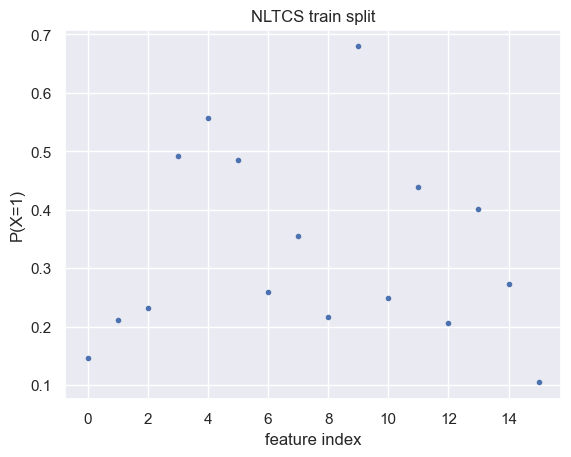

In [58]:
import numpy as np, matplotlib.pyplot as plt
from urllib.request import urlopen
import certifi
import os
os.environ["SSL_CERT_FILE"] = certifi.where()


url = "https://raw.githubusercontent.com/UCLA-StarAI/Density-Estimation-Datasets/refs/heads/master/datasets/nltcs/nltcs.train.data"
with urlopen(url) as f:
    X = np.loadtxt(f, dtype=int, delimiter=",")

print("shape:", X.shape)

p1 = X.mean(axis=0)
plt.plot(p1, ".")
plt.xlabel("feature index")
plt.ylabel("P(X=1)")
plt.title("NLTCS train split")
plt.show()


In [52]:
X

array([], dtype=int64)